In [1]:
import os
import time
import numpy as np
import h5py
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns

from scipy.stats import spearmanr, pearsonr, ranksums

import gc

#PWM sequence logo and score visualization code
import matplotlib

import matplotlib.cm as cm
import matplotlib.colors as colors
import colorsys

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

#Helper function to draw a letter at a given position
def dna_letter_at(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    #Define letter heights and colors
    fp = FontProperties(family="DejaVu Sans", weight="bold")
    globscale = 1.35
    LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
                "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
                "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
                "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
                ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
    COLOR_SCHEME = {'G': 'orange',#'orange', 
                    'A': 'green',#'red', 
                    'C': 'blue',#'blue', 
                    'T': 'red',#'darkgreen',
                    'UP': 'green', 
                    'DN': 'red',
                    '(': 'black',
                    '.': 'black', 
                    ')': 'black'}


    text = LETTERS[letter]

    #Choose color
    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    #Draw letter onto axis
    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    
    return p

#Function to plot a sequence logo of a PWM
def plot_pwm(pwm, figsize=(16, 2), plot_y_ticks=True, y_min=None, y_max=None, save_figs=False, fig_name="default") :
    
    fig = plt.figure(figsize=figsize)

    ax = plt.gca()
    
    height_base = 0.
    logo_height = 1.0
    
    #Conservation = Max_Bits - Entropy
    conservation = 2. - np.sum(-pwm * np.log2(pwm + 1e-6), axis=1)
    
    #Loop over sequence positions
    for j in range(0, pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        #Loop over nucleotide identities
        for ii in range(0, 4) :
            i = sort_index[ii]

            #Calculate prob * conservation
            nt_prob = pwm[j, i] * conservation[j]

            #Decode letter from nucleotide identity
            nt = ''
            if i == 0 :
                nt = 'A'
            elif i == 1 :
                nt = 'C'
            elif i == 2 :
                nt = 'G'
            elif i == 3 :
                nt = 'T'

            #Draw letter at position (height proportional to conservation)
            color = None
            if ii == 0 :
                dna_letter_at(nt, j + 0.5, height_base, nt_prob * logo_height, ax, color=color)
            else :
                prev_prob = np.sum(pwm[j, sort_index[:ii]]) * logo_height  * conservation[j]
                dna_letter_at(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax, color=color)
    
    plt.sca(ax)
    plt.xticks([], [])
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    plt.xlim((0, pwm.shape[0]))
    
    #plt.axis('off')
    
    #Remove x-axis ticks
    if plot_y_ticks :
        plt.yticks(fontsize=12)
    else :
        plt.yticks([], [])
    
    #Set axis limits
    if y_min is not None and y_max is not None :
        plt.ylim(y_min, y_max)
    elif y_min is not None :
        plt.ylim(y_min)
    else :
        plt.ylim(
            min(0., np.min(np.sum(pwm, axis=-1))) - 0.01 * np.max(np.abs(np.sum(pwm, axis=-1))),
            max(0., np.max(np.sum(pwm, axis=-1))) + 0.01 * np.max(np.abs(np.sum(pwm, axis=-1)))
        )
    
    plt.axhline(y=0., color='black', linestyle='-', linewidth=1)

    #for axis in fig.axes :
    #    axis.get_xaxis().set_visible(False)
    #    axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()


- metacluster_0_pattern_0 -
- n = 4163


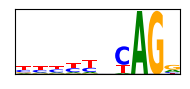

- metacluster_0_pattern_32 -
- n = 401


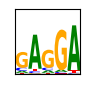

- metacluster_0_pattern_50 -
- n = 154


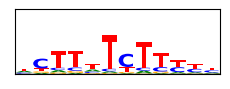

In [2]:
#Find and plot chosen metacluster pwms from modisco results file

save_figs = True

ic_t = 0.1
gc_content = 0.41

modisco_file = 'gtex_splice3_undo_clip_4_folds_3/tfm.h5'

modisco_names = [
    'ACCEPTOR',
    'SRSF1',
    'PTBP1',
]

modisco_clusters = [
    'metacluster_0_pattern_0',
    'metacluster_0_pattern_32',
    'metacluster_0_pattern_50',
]

#Function to clip PWMs by IC
def ic_clip(pwm, threshold, background=[0.25]*4):
    
    pc = 0.001
    odds_ratio = ((pwm+pc)/(1+4*pc)) / (background[None,:])
    ic = (np.log((pwm+pc)/(1+4*pc)) / np.log(2))*pwm
    ic -= (np.log(background)*background/np.log(2))[None,:]
    ic_total = np.sum(ic,axis=1)[:,None]

    #No bp pass threshold
    if ~np.any(ic_total.flatten()>threshold):
        return None, 0, pwm.shape[0]
    else:
        left = np.where(ic_total>threshold)[0][0]
        right = np.where(ic_total>threshold)[0][-1]
        return pwm[left:(right+1)], left, right+1

#Plot modisco PWMs

#Load h5 file
with h5py.File(modisco_file, 'r') as tfm_h5 :
    
    #Loop over clusters
    for pwm_i, [name, cluster] in enumerate(zip(modisco_names, modisco_clusters)) :
        
        metacluster_ix = int(cluster.split("etacluster_")[1].split("_pattern")[0])
        pattern_ix = int(cluster.split("pattern_")[1])
        
        #Load PWM (not GC-clipped)
        pwm_unclipped = tfm_h5["metacluster_idx_to_submetacluster_results"]['metacluster_' + str(metacluster_ix)]['seqlets_to_patterns_result']['patterns']['pattern_' + str(pattern_ix)]['sequence']['fwd'][()]
        
        #Get number of seqlets from strings
        seqlet_strs = tfm_h5["metacluster_idx_to_submetacluster_results"]['metacluster_' + str(metacluster_ix)]['seqlets_to_patterns_result']['patterns']['pattern_' + str(pattern_ix)]['seqlets_and_alnmts']['seqlets'][()]
        seqlet_strs = [seqlet_str.decode() for seqlet_str in seqlet_strs]
        
        #Calculate AT/GC background frequencies
        at_pct = (1-gc_content)/2
        gc_pct = gc_content/2
        background = np.array([at_pct, gc_pct, gc_pct, at_pct])

        #Clip by IC
        pwm, _, _ = ic_clip(pwm_unclipped, ic_t, background)
        
        print("- " + cluster + " -")
        print("- n = " + str(len(seqlet_strs)))
        
        #Plot PWM
        plot_pwm(pwm, figsize=(0.2 * pwm.shape[0], 1), y_min=0., y_max=2., plot_y_ticks=False, save_figs=save_figs, fig_name="attribution_figs/" + name.replace("/", "_") + "_" + cluster)
